In [1]:
%matplotlib inline

In [2]:
#!pip install gluoncv==0.5.0

In [3]:
import zipfile, os
from gluoncv.utils import download

file_url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/minc-2500-tiny.zip'
zip_file = download(file_url, path='./')
with zipfile.ZipFile(zip_file, 'r') as zin:
    zin.extractall(os.path.expanduser('./'))

Hyperparameters
----------

First, let's import all other necessary libraries.



In [4]:
import mxnet as mx
import numpy as np
import os, time, shutil

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model

We set the hyperparameters as following:



In [5]:
# class: brown, polar, no bear
classes = 3

epochs = 100
#lr = 0.001
lr = 0.01
#per_device_batch_size = 1
per_device_batch_size = 256
#momentum = 0.9
#wd = 0.0001

#lr_factor = 0.75
#lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)

Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

Data Augmentation
-----------------

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [6]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, 
                                 contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

With the data augmentation functions, we can define our data loaders:



In [7]:
path = './download-data/data'

train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./download-data/data/train/brown/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./download-data/data/train/no/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./download-data/data/train/polar/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:312: UserWarning: Ignoring ./download-data/data/val/brown/.ipynb_checkpoints of type . Only support .jpg, .jpeg,

Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

Model and Trainer
-----------------

We use a pre-trained ``ResNet50_v2`` model, which has balanced accuracy and
computation cost.



In [8]:
#model_name = 'ResNet50_v2'
model_name = 'MobileNet1.0'
finetune_net = get_model(model_name, pretrained=True)

In [9]:
for idx, class_name in enumerate(finetune_net.classes):
    if 'bear' in class_name:
        print(class_name)

brown bear
American black bear
ice bear
sloth bear
bearskin


In [10]:
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

#trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
#                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
trainer = gluon.Trainer(finetune_net.collect_params(), 'adam', 
                        {'learning_rate': lr})

metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

In [11]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

Training Loop
-------------

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

In [12]:
#lr_counter = 0
num_batch = len(train_data)

for epoch in range(epochs):
#    if epoch == lr_steps[lr_counter]:
#        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
#        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, val_data, ctx)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.438, loss: 2.149 | Val-acc: 0.412 | time: 14.9
[Epoch 1] Train-acc: 0.568, loss: 0.970 | Val-acc: 0.176 | time: 5.9
[Epoch 2] Train-acc: 0.615, loss: 0.904 | Val-acc: 0.397 | time: 5.8
[Epoch 3] Train-acc: 0.646, loss: 0.833 | Val-acc: 0.603 | time: 5.6
[Epoch 4] Train-acc: 0.699, loss: 0.745 | Val-acc: 0.676 | time: 5.6
[Epoch 5] Train-acc: 0.692, loss: 0.742 | Val-acc: 0.603 | time: 5.8
[Epoch 6] Train-acc: 0.720, loss: 0.737 | Val-acc: 0.426 | time: 5.3
[Epoch 7] Train-acc: 0.738, loss: 0.688 | Val-acc: 0.735 | time: 5.8
[Epoch 8] Train-acc: 0.747, loss: 0.654 | Val-acc: 0.721 | time: 5.9
[Epoch 9] Train-acc: 0.747, loss: 0.621 | Val-acc: 0.706 | time: 5.6
[Epoch 10] Train-acc: 0.777, loss: 0.598 | Val-acc: 0.618 | time: 5.7
[Epoch 11] Train-acc: 0.759, loss: 0.621 | Val-acc: 0.691 | time: 5.9
[Epoch 12] Train-acc: 0.771, loss: 0.565 | Val-acc: 0.853 | time: 5.9
[Epoch 13] Train-acc: 0.791, loss: 0.557 | Val-acc: 0.618 | time: 5.8
[Epoch 14] Train-acc: 0.790, 

# FOR DEEPLENS DEPLOYMENT

In [13]:
model_name = 'resnet20_v1-minc-tiny'

finetune_net.export(model_name)

net_with_softmax = finetune_net(mx.sym.var('data'))
net_with_softmax = mx.sym.SoftmaxOutput(data=net_with_softmax, name='softmax')
net_with_softmax.save('./{}-symbol.json'.format(model_name))

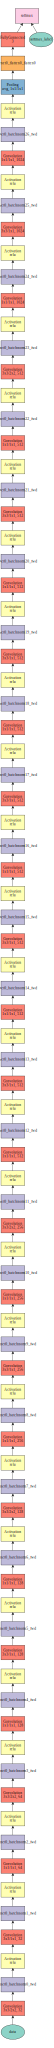

In [14]:
mx.viz.plot_network(net_with_softmax)

In [15]:
!ls -l $model_name*

-rw-rw-r-- 1 ubuntu ubuntu 12938464 Nov  4 08:12 resnet20_v1-minc-tiny-0000.params
-rw-rw-r-- 1 ubuntu ubuntu    69811 Nov  4 08:12 resnet20_v1-minc-tiny-symbol.json


In [16]:
# !tar cvfz ./{model_name}.tar.gz ./{model_name}-*

In [17]:
# !aws s3 cp {model_name}.tar.gz s3://deeplens-mh-s3-us-east-1/models/